<div style="text-align: right">   </div>


Introduction to Deep Learning (2023) &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;| &nbsp;
-------|-------------------
**Assignment 2 - Recurrent Neural Networks** | <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/UniversiteitLeidenLogo.svg/1280px-UniversiteitLeidenLogo.svg.png" width="300">



# Introduction


The goal of this assignment is to learn how to use encoder-decoder recurrent neural networks (RNNs). Specifically we will be dealing with a sequence to sequence problem and try to build recurrent models that can learn the principles behind simple arithmetic operations (**integer addition, subtraction and multiplication.**).

<img src="https://i.ibb.co/5Ky5pbk/Screenshot-2023-11-10-at-07-51-21.png" alt="Screenshot-2023-11-10-at-07-51-21" border="0" width="500"></a>

In this assignment you will be working with three different kinds of models, based on input/output data modalities:
1. **Text-to-text**: given a text query containing two integers and an operand between them (+ or -) the model's output should be a sequence of integers that match the actual arithmetic result of this operation
2. **Image-to-text**: same as above, except the query is specified as a sequence of images containing individual digits and an operand.
3. **Text-to-image**: the query is specified in text format as in the text-to-text model, however the model's output should be a sequence of images corresponding to the correct result.


### Description**
Let us suppose that we want to develop a neural network that learns how to add or subtract
two integers that are at most two digits long. For example, given input strings of 5 characters: ‘81+24’ or
’41-89’ that consist of 2 two-digit long integers and an operand between them, the network should return a
sequence of 3 characters: ‘105 ’ or ’-48 ’ that represent the result of their respective queries. Additionally,
we want to build a model that generalizes well - if the network can extract the underlying principles behind
the ’+’ and ’-’ operands and associated operations, it should not need too many training examples to generate
valid answers to unseen queries. To represent such queries we need 13 unique characters: 10 for digits (0-9),
2 for the ’+’ and ’-’ operands and one for whitespaces ’ ’ used as padding.
The example above describes a text-to-text sequence mapping scenario. However, we can also use different
modalities of data to represent our queries or answers. For that purpose, the MNIST handwritten digit
dataset is going to be used again, however in a slightly different format. The functions below will be used to create our datasets.

---

*To work on this notebook you should create a copy of it.*


# Function definitions for creating the datasets

First we need to create our datasets that are going to be used for training our models.

In order to create image queries of simple arithmetic operations such as '15+13' or '42-10' we need to create images of '+' and '-' signs using ***open-cv*** library. We will use these operand signs together with the MNIST dataset to represent the digits.

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, RNN, LSTM, Flatten, TimeDistributed, LSTMCell
from tensorflow.keras.layers import (
    RepeatVector,
    Conv2D,
    SimpleRNN,
    GRU,
    Reshape,
    ConvLSTM2D,
    Conv2DTranspose,
)

2023-12-06 15:05:33.990635: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from scipy.ndimage import rotate


# Create plus/minus operand signs
def generate_images(number_of_images=50, sign="-"):
    blank_images = np.zeros(
        [number_of_images, 28, 28]
    )  # Dimensionality matches the size of MNIST images (28x28)
    x = np.random.randint(12, 16, (number_of_images, 2))  # Randomized x coordinates
    y1 = np.random.randint(6, 10, number_of_images)  # Randomized y coordinates
    y2 = np.random.randint(18, 22, number_of_images)  # -||-

    for i in range(number_of_images):  # Generate n different images
        cv2.line(
            blank_images[i],
            (y1[i], x[i, 0]),
            (y2[i], x[i, 1]),
            (255, 0, 0),
            2,
            cv2.LINE_AA,
        )  # Draw lines with randomized coordinates
        if sign == "+":
            cv2.line(
                blank_images[i],
                (x[i, 0], y1[i]),
                (x[i, 1], y2[i]),
                (255, 0, 0),
                2,
                cv2.LINE_AA,
            )  # Draw lines with randomized coordinates
        if sign == "*":
            cv2.line(
                blank_images[i],
                (x[i, 0], y1[i]),
                (x[i, 1], y2[i]),
                (255, 0, 0),
                2,
                cv2.LINE_AA,
            )
            # Rotate 45 degrees
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(
                blank_images[i],
                (x[i, 0], y1[i]),
                (x[i, 1], y2[i]),
                (255, 0, 0),
                2,
                cv2.LINE_AA,
            )
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(
                blank_images[i],
                (x[i, 0], y1[i]),
                (x[i, 1], y2[i]),
                (255, 0, 0),
                2,
                cv2.LINE_AA,
            )

    return blank_images


def show_generated(images, n=5):
    plt.figure(figsize=(2, 2))
    for i in range(n**2):
        plt.subplot(n, n, i + 1)
        plt.axis("off")
        plt.imshow(images[i])
    plt.show()


# show_generated(generate_images())
# show_generated(generate_images(sign="+"))

In [4]:
def create_data(highest_integer, num_addends=2, operands=["+", "-"]):
    """
    Creates the following data for all pairs of integers up to [1:highest integer][+/-][1:highest_integer]:

    @return:
    X_text: '51+21' -> text query of an arithmetic operation (5)
    X_img : Stack of MNIST images corresponding to the query (5 x 28 x 28) -> sequence of 5 images of size 28x28
    y_text: '72' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (3 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels == x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping["-"] = generate_images()
    image_mapping["+"] = generate_images(sign="+")
    image_mapping["*"] = generate_images(sign="*")
    image_mapping[" "] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []

    for i in range(highest_integer + 1):  # First addend
        for j in range(highest_integer + 1):  # Second addend
            for sign in operands:  # Create all possible combinations of operands
                query_string = to_padded_chars(
                    str(i) + sign + str(j), max_len=max_query_length, pad_right=True
                )
                query_image = []
                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(
                    result, max_len=max_answer_length, pad_right=True
                )
                result_image = []
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())

                X_text.append(query_string)
                X_img.append(np.stack(query_image))
                y_text.append(result_string)
                y_img.append(np.stack(result_image))

    return (
        np.stack(X_text),
        np.stack(X_img) / 255.0,
        np.stack(y_text),
        np.stack(y_img) / 255.0,
    )


def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * " "
    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)

# Creating our data

The dataset consists of 20000 samples that (additions and subtractions between all 2-digit integers) and they have two kinds of inputs and label modalities:

  **X_text**: strings containing queries of length 5: ['  1+1  ', '11-18', ...]

  **X_image**: a stack of images representing a single query, dimensions: [5, 28, 28]

  **y_text**: strings containing answers of length 3: ['  2', '156']

  **y_image**: a stack of images that represents the answer to a query, dimensions: [3, 28, 28]

In [5]:
# Illustrate the generated query/answer pairs

unique_characters = "0123456789+- "  # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99  # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))  # Maximum number of characters in an integer
max_query_length = (
    max_int_length * 2 + 1
)  # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 3  # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer)
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)


## Display the samples that were created
def display_sample(n):
    labels = ["X_img:", "y_img:"]
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1, 2, i + 1)
        # plt.set_figheight(15)
        plt.axis("off")
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap="gray")
    print("=" * 50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()


"""for _ in range(10):
    display_sample(np.random.randint(0, 10000, 1)[0])"""

(20000,) (20000, 5, 28, 28) (20000,) (20000, 3, 28, 28)


'for _ in range(10):\n    display_sample(np.random.randint(0, 10000, 1)[0])'

## Helper functions

The functions below will help with input/output of the data.

In [6]:
# One-hot encoding/decoding the text queries/answers so that they can be processed using RNNs
# You should use these functions to convert your strings and read out the output of your networks


def encode_labels(labels, max_len=3):
    n = len(labels)
    length = len(labels[0])
    char_map = dict(zip(unique_characters, range(len(unique_characters))))
    one_hot = np.zeros([n, length, len(unique_characters)])
    for i, label in enumerate(labels):
        m = np.zeros([length, len(unique_characters)])
        for j, char in enumerate(label):
            m[j, char_map[char]] = 1
        one_hot[i] = m

    return one_hot


def decode_labels(labels):
    pred = np.argmax(labels, axis=1)
    predicted = "".join([unique_characters[i] for i in pred])

    return predicted


X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

print(X_text_onehot.shape, y_text_onehot.shape)

(20000, 5, 13) (20000, 3, 13)


---
---

## I. Text-to-text RNN model

The following code showcases how Recurrent Neural Networks (RNNs) are built using Keras. Several new layers are going to be used:

1. LSTM
2. TimeDistributed
3. RepeatVector

The code cell below explains each of these new components.

<img src="https://i.ibb.co/NY7FFTc/Screenshot-2023-11-10-at-09-27-25.png" alt="Screenshot-2023-11-10-at-09-27-25" border="0" width="500"></a>


In [7]:
def build_text2text_model():
    # We start by initializing a sequential model
    text2text = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. Each of these 5 elements in the query will be fed to the network one by one,
    # as shown in the image above (except with 5 elements).
    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
    text2text.add(LSTM(256, input_shape=(None, len(unique_characters))))

    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    text2text.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    text2text.add(LSTM(256, return_sequences=True))

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    text2text.add(TimeDistributed(Dense(len(unique_characters), activation="softmax")))

    # Next we compile the model using categorical crossentropy as our loss function.
    text2text.compile(
        loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    text2text.summary()

    return text2text


---
---

## II. Image to text RNN Model

Hint: There are two ways of building the encoder for such a model - again by using the regular LSTM cells (with flattened images as vectors) or recurrect convolutional layers [ConvLSTM2D](https://keras.io/api/layers/recurrent_layers/conv_lstm2d/).

The goal here is to use **X_img** as inputs and **y_text** as outputs.

In [8]:
## Your code


def build_image_to_text_model():
    # Define the input shape
    input_shape = (5, 28, 28)  # 5 images of size 28x28 each

    # Define the model
    img2text = tf.keras.Sequential()

    # Flatten the input and feed it into the LSTM encoder
    img2text.add(TimeDistributed(Flatten(), input_shape=input_shape))
    img2text.add(LSTM(384))

    # Repeat the encoder output
    img2text.add(RepeatVector(max_answer_length))

    # Decoder to generate the output sequence
    img2text.add(LSTM(384, return_sequences=True))

    # Apply a dense layer to each time step
    img2text.add(TimeDistributed(Dense(len(unique_characters), activation="softmax")))

    # Compile the model
    img2text.compile(
        loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )

    img2text.summary()

    return img2text


# add one additional LSTM to the model
def build_image_to_text_model_v2():
    # Define the input shape
    input_shape = (5, 28, 28)  # 5 images of size 28x28 each

    # Define the model
    img2text = tf.keras.Sequential()

    # Flatten the input and feed it into the LSTM encoder
    img2text.add(TimeDistributed(Flatten(), input_shape=input_shape))
    img2text.add(LSTM(384, return_sequences=True))
    img2text.add(LSTM(384))

    # Repeat the encoder output
    img2text.add(RepeatVector(max_answer_length))

    # Decoder to generate the output sequence
    img2text.add(LSTM(384, return_sequences=True))

    # Apply a dense layer to each time step
    img2text.add(TimeDistributed(Dense(len(unique_characters), activation="softmax")))

    # Compile the model
    img2text.compile(
        loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )

    img2text.summary()

    return img2text


# add one additional LSTM to the model
def build_image_to_text_model_v3():
    # Define the input shape
    input_shape = (5, 28, 28)  # 5 images of size 28x28 each

    # Define the model
    img2text = tf.keras.Sequential()

    # Flatten the input and feed it into the LSTM encoder
    img2text.add(TimeDistributed(Flatten(), input_shape=input_shape))
    img2text.add(LSTM(384, return_sequences=True))
    img2text.add(LSTM(384, return_sequences=True))
    img2text.add(LSTM(384))

    # Repeat the encoder output
    img2text.add(RepeatVector(max_answer_length))

    # Decoder to generate the output sequence
    img2text.add(LSTM(384, return_sequences=True))

    # Apply a dense layer to each time step
    img2text.add(TimeDistributed(Dense(len(unique_characters), activation="softmax")))

    # Compile the model
    img2text.compile(
        loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )

    img2text.summary()

    return img2text

In [9]:
def train_and_evaluate(split_ratio, X_data, y_data, model):
    # Splitting the dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, test_size=split_ratio, random_state=42
    )

    # Training the model
    model.fit(
        X_train,
        y_train,
        epochs=20,
        batch_size=32,
        validation_data=(X_test, y_test),
    )

    # Evaluating the model
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

    # Predicting and comparing with true labels
    predictions = model.predict(X_test)

    true_labels = []
    predicted_labels = []

    for i in range(len(X_test)):
        true_label = decode_labels(y_test[i])
        predicted_label = decode_labels(predictions[i])

        true_labels.append(true_label)
        predicted_labels.append(predicted_label)

    # Return the accuracy and the labels for visualization
    return accuracy, true_labels, predicted_labels


# Modified training and evaluation for different splits
splits = [0.5, 0.75, 0.9]  # Train-test splits, the number is the ratio of test data
results_p1_2_v1 = {}

for split in splits:
    print(f"Training with {1-split} Train - {split} Test split")
    accuracy, true_labels, predicted_labels = train_and_evaluate(
        split, X_img, y_text_onehot, build_image_to_text_model()
    )
    results_p1_2_v1[split] = {
        "accuracy": accuracy,
        "true_labels": true_labels,
        "predicted_labels": predicted_labels,
    }

Training with 0.5 Train - 0.5 Test split


2023-12-06 15:06:25.463642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 15:06:25.464594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 15:06:25.465681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 5, 784)           0         
 ibuted)                                                         
                                                                 
 lstm (LSTM)                 (None, 384)               1795584   
                                                                 
 repeat_vector (RepeatVector  (None, 3, 384)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 3, 384)            1181184   
                                                                 
 time_distributed_1 (TimeDis  (None, 3, 13)            5005      
 tributed)                                                       
                                                        

2023-12-06 15:06:25.710619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 15:06:25.711668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 15:06:25.712850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2023-12-06 15:06:26.584612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 15:06:26.586369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 15:06:26.587712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

312/313 [============================>.] - ETA: 0s - loss: 1.9263 - accuracy: 0.3674

2023-12-06 15:06:48.524040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 15:06:48.525297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 15:06:48.526232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

313/313 [==============================] - 27s 74ms/step - loss: 1.9260 - accuracy: 0.3673 - val_loss: 1.7332 - val_accuracy: 0.4030
Epoch 2/20
313/313 [==============================] - 23s 73ms/step - loss: 1.6496 - accuracy: 0.4185 - val_loss: 1.5841 - val_accuracy: 0.4350
Epoch 3/20
313/313 [==============================] - 25s 79ms/step - loss: 1.5166 - accuracy: 0.4518 - val_loss: 1.5110 - val_accuracy: 0.4541
Epoch 4/20
313/313 [==============================] - 23s 73ms/step - loss: 1.4127 - accuracy: 0.4851 - val_loss: 1.4807 - val_accuracy: 0.4658
Epoch 5/20
313/313 [==============================] - 21s 67ms/step - loss: 1.3219 - accuracy: 0.5150 - val_loss: 1.4760 - val_accuracy: 0.4694
Epoch 6/20
313/313 [==============================] - 21s 66ms/step - loss: 1.2325 - accuracy: 0.5418 - val_loss: 1.4845 - val_accuracy: 0.4788
Epoch 7/20
313/313 [==============================] - 21s 67ms/step - loss: 1.1408 - accuracy: 0.5765 - val_loss: 1.4897 - val_accuracy: 0.4835
Epo

2023-12-06 15:13:51.067062: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 15:13:51.069230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 15:13:51.070310: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

313/313 [==============================] - 6s 17ms/step
Training with 0.25 Train - 0.75 Test split


2023-12-06 15:13:57.364218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 15:13:57.365529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 15:13:57.366657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDis  (None, 5, 784)           0         
 tributed)                                                       
                                                                 
 lstm_2 (LSTM)               (None, 384)               1795584   
                                                                 
 repeat_vector_1 (RepeatVect  (None, 3, 384)           0         
 or)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 3, 384)            1181184   
                                                                 
 time_distributed_3 (TimeDis  (None, 3, 13)            5005      
 tributed)                                                       
                                                      

2023-12-06 15:13:57.638644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 15:13:57.640551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 15:13:57.641906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2023-12-06 15:13:58.672845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 15:13:58.674210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 15:13:58.675667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

157/157 [==============================] - ETA: 0s - loss: 2.0464 - accuracy: 0.3415

2023-12-06 15:14:14.413823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 15:14:14.415422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 15:14:14.416745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

157/157 [==============================] - 24s 128ms/step - loss: 2.0464 - accuracy: 0.3415 - val_loss: 1.8628 - val_accuracy: 0.3928
Epoch 2/20
157/157 [==============================] - 20s 128ms/step - loss: 1.7980 - accuracy: 0.3927 - val_loss: 1.7491 - val_accuracy: 0.3942
Epoch 3/20
157/157 [==============================] - 20s 131ms/step - loss: 1.6702 - accuracy: 0.4152 - val_loss: 1.6574 - val_accuracy: 0.4145
Epoch 4/20
157/157 [==============================] - 20s 130ms/step - loss: 1.5723 - accuracy: 0.4391 - val_loss: 1.6131 - val_accuracy: 0.4313
Epoch 5/20
157/157 [==============================] - 21s 131ms/step - loss: 1.4816 - accuracy: 0.4644 - val_loss: 1.5839 - val_accuracy: 0.4332
Epoch 6/20
157/157 [==============================] - 20s 131ms/step - loss: 1.3896 - accuracy: 0.4929 - val_loss: 1.6015 - val_accuracy: 0.4374
Epoch 7/20
157/157 [==============================] - 20s 128ms/step - loss: 1.3019 - accuracy: 0.5228 - val_loss: 1.6723 - val_accuracy: 0.4

2023-12-06 15:20:52.428152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 15:20:52.430335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 15:20:52.431513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

469/469 [==============================] - 8s 16ms/step
Training with 0.09999999999999998 Train - 0.9 Test split


2023-12-06 15:21:00.805636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 15:21:00.807467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 15:21:00.808579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 5, 784)           0         
 tributed)                                                       
                                                                 
 lstm_4 (LSTM)               (None, 384)               1795584   
                                                                 
 repeat_vector_2 (RepeatVect  (None, 3, 384)           0         
 or)                                                             
                                                                 
 lstm_5 (LSTM)               (None, 3, 384)            1181184   
                                                                 
 time_distributed_5 (TimeDis  (None, 3, 13)            5005      
 tributed)                                                       
                                                      

2023-12-06 15:21:01.112783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 15:21:01.114624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 15:21:01.116121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2023-12-06 15:21:01.855300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 15:21:01.856682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 15:21:01.858207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

63/63 [==============================] - ETA: 0s - loss: 2.1846 - accuracy: 0.2917

2023-12-06 15:21:10.313612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 15:21:10.315017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 15:21:10.316481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

63/63 [==============================] - 18s 239ms/step - loss: 2.1846 - accuracy: 0.2917 - val_loss: 2.0427 - val_accuracy: 0.3325
Epoch 2/20
63/63 [==============================] - 14s 225ms/step - loss: 1.9991 - accuracy: 0.3595 - val_loss: 1.9406 - val_accuracy: 0.3887
Epoch 3/20
63/63 [==============================] - 14s 224ms/step - loss: 1.8709 - accuracy: 0.3902 - val_loss: 1.8941 - val_accuracy: 0.3837
Epoch 4/20
63/63 [==============================] - 14s 224ms/step - loss: 1.7758 - accuracy: 0.4032 - val_loss: 1.7982 - val_accuracy: 0.3896
Epoch 5/20
63/63 [==============================] - 14s 222ms/step - loss: 1.6720 - accuracy: 0.4192 - val_loss: 1.7901 - val_accuracy: 0.3894
Epoch 6/20
63/63 [==============================] - 14s 221ms/step - loss: 1.5730 - accuracy: 0.4412 - val_loss: 1.8164 - val_accuracy: 0.3950
Epoch 7/20
63/63 [==============================] - 14s 230ms/step - loss: 1.4812 - accuracy: 0.4740 - val_loss: 1.8236 - val_accuracy: 0.3870
Epoch 8/20

2023-12-06 15:25:14.729565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 15:25:14.730539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 15:25:14.731800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

563/563 [==============================] - 7s 12ms/step


In [10]:
# the out put from model with two LSTM layers in encoder
results_p1_2_v2 = {}

for split in splits:
    print(f"Training with {1-split} Train - {split} Test split")
    accuracy, true_labels, predicted_labels = train_and_evaluate(
        split, X_img, y_text_onehot, build_image_to_text_model_v2()
    )
    results_p1_2_v2[split] = {
        "accuracy": accuracy,
        "true_labels": true_labels,
        "predicted_labels": predicted_labels,
    }

Training with 0.5 Train - 0.5 Test split


2023-12-06 15:25:22.567779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 15:25:22.568735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 15:25:22.569837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, 5, 784)           0         
 tributed)                                                       
                                                                 
 lstm_6 (LSTM)               (None, 5, 384)            1795584   
                                                                 
 lstm_7 (LSTM)               (None, 384)               1181184   
                                                                 
 repeat_vector_3 (RepeatVect  (None, 3, 384)           0         
 or)                                                             
                                                                 
 lstm_8 (LSTM)               (None, 3, 384)            1181184   
                                                                 
 time_distributed_7 (TimeDis  (None, 3, 13)           

2023-12-06 15:25:23.023488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 15:25:23.024476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 15:25:23.025748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2023-12-06 15:25:23.704040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 15:25:23.705159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 15:25:23.706304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

313/313 [==============================] - ETA: 0s - loss: 1.9732 - accuracy: 0.3556

2023-12-06 15:25:53.086051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 15:25:53.087114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 15:25:53.088207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

313/313 [==============================] - 35s 98ms/step - loss: 1.9732 - accuracy: 0.3556 - val_loss: 1.7231 - val_accuracy: 0.4007
Epoch 2/20
313/313 [==============================] - 31s 98ms/step - loss: 1.6469 - accuracy: 0.4207 - val_loss: 1.5639 - val_accuracy: 0.4441
Epoch 3/20
313/313 [==============================] - 31s 100ms/step - loss: 1.5069 - accuracy: 0.4580 - val_loss: 1.4892 - val_accuracy: 0.4633
Epoch 4/20
313/313 [==============================] - 30s 95ms/step - loss: 1.3861 - accuracy: 0.4950 - val_loss: 1.4100 - val_accuracy: 0.4939
Epoch 5/20
313/313 [==============================] - 31s 98ms/step - loss: 1.2837 - accuracy: 0.5273 - val_loss: 1.3465 - val_accuracy: 0.5166
Epoch 6/20
313/313 [==============================] - 30s 98ms/step - loss: 1.1859 - accuracy: 0.5610 - val_loss: 1.3243 - val_accuracy: 0.5286
Epoch 7/20
313/313 [==============================] - 33s 104ms/step - loss: 1.1101 - accuracy: 0.5869 - val_loss: 1.2921 - val_accuracy: 0.5392
E

2023-12-06 15:36:07.399229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 15:36:07.400403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 15:36:07.401529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

313/313 [==============================] - 6s 17ms/step
Training with 0.25 Train - 0.75 Test split


2023-12-06 15:36:13.893704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 15:36:13.895503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 15:36:13.896449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDis  (None, 5, 784)           0         
 tributed)                                                       
                                                                 
 lstm_9 (LSTM)               (None, 5, 384)            1795584   
                                                                 
 lstm_10 (LSTM)              (None, 384)               1181184   
                                                                 
 repeat_vector_4 (RepeatVect  (None, 3, 384)           0         
 or)                                                             
                                                                 
 lstm_11 (LSTM)              (None, 3, 384)            1181184   
                                                                 
 time_distributed_9 (TimeDis  (None, 3, 13)           

2023-12-06 15:36:14.348546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 15:36:14.349542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 15:36:14.350659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2023-12-06 15:36:14.951373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 15:36:14.952649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 15:36:14.953865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

157/157 [==============================] - ETA: 0s - loss: 2.0772 - accuracy: 0.3343

2023-12-06 15:36:32.059318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 15:36:32.060839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 15:36:32.061967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

157/157 [==============================] - 27s 143ms/step - loss: 2.0772 - accuracy: 0.3343 - val_loss: 2.0120 - val_accuracy: 0.3560
Epoch 2/20
157/157 [==============================] - 21s 136ms/step - loss: 1.8255 - accuracy: 0.3918 - val_loss: 1.7289 - val_accuracy: 0.4012
Epoch 3/20
157/157 [==============================] - 21s 136ms/step - loss: 1.6740 - accuracy: 0.4151 - val_loss: 1.6247 - val_accuracy: 0.4284
Epoch 4/20
157/157 [==============================] - 21s 134ms/step - loss: 1.5744 - accuracy: 0.4370 - val_loss: 1.5818 - val_accuracy: 0.4370
Epoch 5/20
157/157 [==============================] - 20s 129ms/step - loss: 1.4928 - accuracy: 0.4613 - val_loss: 1.5504 - val_accuracy: 0.4499
Epoch 6/20
157/157 [==============================] - 20s 129ms/step - loss: 1.4059 - accuracy: 0.4815 - val_loss: 1.5303 - val_accuracy: 0.4583
Epoch 7/20
157/157 [==============================] - 22s 140ms/step - loss: 1.3299 - accuracy: 0.5078 - val_loss: 1.5170 - val_accuracy: 0.4

2023-12-06 15:43:41.963637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 15:43:41.964631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 15:43:41.965674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

469/469 [==============================] - 9s 18ms/step
Training with 0.09999999999999998 Train - 0.9 Test split


2023-12-06 15:43:51.567080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 15:43:51.569013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 15:43:51.569989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_10 (TimeDi  (None, 5, 784)           0         
 stributed)                                                      
                                                                 
 lstm_12 (LSTM)              (None, 5, 384)            1795584   
                                                                 
 lstm_13 (LSTM)              (None, 384)               1181184   
                                                                 
 repeat_vector_5 (RepeatVect  (None, 3, 384)           0         
 or)                                                             
                                                                 
 lstm_14 (LSTM)              (None, 3, 384)            1181184   
                                                                 
 time_distributed_11 (TimeDi  (None, 3, 13)           

2023-12-06 15:43:52.021670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 15:43:52.023149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 15:43:52.024173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2023-12-06 15:43:52.617660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 15:43:52.619036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 15:43:52.620118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

63/63 [==============================] - ETA: 0s - loss: 2.1814 - accuracy: 0.3002

2023-12-06 15:44:02.202570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 15:44:02.203824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 15:44:02.205059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

63/63 [==============================] - 19s 241ms/step - loss: 2.1814 - accuracy: 0.3002 - val_loss: 2.0470 - val_accuracy: 0.3190
Epoch 2/20
63/63 [==============================] - 13s 216ms/step - loss: 1.9953 - accuracy: 0.3630 - val_loss: 1.9124 - val_accuracy: 0.3899
Epoch 3/20
63/63 [==============================] - 14s 223ms/step - loss: 1.8774 - accuracy: 0.3852 - val_loss: 1.8797 - val_accuracy: 0.3907
Epoch 4/20
63/63 [==============================] - 14s 232ms/step - loss: 1.7806 - accuracy: 0.3935 - val_loss: 1.7628 - val_accuracy: 0.3966
Epoch 5/20
63/63 [==============================] - 15s 245ms/step - loss: 1.6937 - accuracy: 0.4065 - val_loss: 1.7258 - val_accuracy: 0.4069
Epoch 6/20
63/63 [==============================] - 17s 267ms/step - loss: 1.6211 - accuracy: 0.4205 - val_loss: 1.7509 - val_accuracy: 0.3975
Epoch 7/20
63/63 [==============================] - 16s 262ms/step - loss: 1.5603 - accuracy: 0.4390 - val_loss: 1.7940 - val_accuracy: 0.3894
Epoch 8/20

2023-12-06 15:49:16.655841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 15:49:16.656798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 15:49:16.657891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

563/563 [==============================] - 11s 19ms/step


In [11]:
# the out put from model with two LSTM layers in encoder
results_p1_2_v3 = {}

for split in splits:
    print(f"Training with {1-split} Train - {split} Test split")
    accuracy, true_labels, predicted_labels = train_and_evaluate(
        split, X_img, y_text_onehot, build_image_to_text_model_v3()
    )
    results_p1_2_v3[split] = {
        "accuracy": accuracy,
        "true_labels": true_labels,
        "predicted_labels": predicted_labels,
    }

Training with 0.5 Train - 0.5 Test split


2023-12-06 15:49:28.369086: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 15:49:28.370020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 15:49:28.371182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeDi  (None, 5, 784)           0         
 stributed)                                                      
                                                                 
 lstm_15 (LSTM)              (None, 5, 384)            1795584   
                                                                 
 lstm_16 (LSTM)              (None, 5, 384)            1181184   
                                                                 
 lstm_17 (LSTM)              (None, 384)               1181184   
                                                                 
 repeat_vector_6 (RepeatVect  (None, 3, 384)           0         
 or)                                                             
                                                                 
 lstm_18 (LSTM)              (None, 3, 384)           

2023-12-06 15:49:29.038358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 15:49:29.039436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 15:49:29.040583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2023-12-06 15:49:29.701179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 15:49:29.702401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 15:49:29.703640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

313/313 [==============================] - ETA: 0s - loss: 1.9539 - accuracy: 0.3626

2023-12-06 15:50:11.418576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 15:50:11.419581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 15:50:11.420709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

313/313 [==============================] - 51s 145ms/step - loss: 1.9539 - accuracy: 0.3626 - val_loss: 1.7305 - val_accuracy: 0.4004
Epoch 2/20
313/313 [==============================] - 42s 135ms/step - loss: 1.6354 - accuracy: 0.4230 - val_loss: 1.5628 - val_accuracy: 0.4442
Epoch 3/20
313/313 [==============================] - 41s 132ms/step - loss: 1.5004 - accuracy: 0.4593 - val_loss: 1.4661 - val_accuracy: 0.4716
Epoch 4/20
313/313 [==============================] - 42s 134ms/step - loss: 1.3857 - accuracy: 0.4961 - val_loss: 1.4126 - val_accuracy: 0.4914
Epoch 5/20
313/313 [==============================] - 42s 133ms/step - loss: 1.2847 - accuracy: 0.5305 - val_loss: 1.3316 - val_accuracy: 0.5225
Epoch 6/20
313/313 [==============================] - 42s 135ms/step - loss: 1.1860 - accuracy: 0.5677 - val_loss: 1.2932 - val_accuracy: 0.5378
Epoch 7/20
313/313 [==============================] - 42s 134ms/step - loss: 1.1119 - accuracy: 0.5915 - val_loss: 1.2479 - val_accuracy: 0.5

2023-12-06 16:03:39.779999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 16:03:39.781035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 16:03:39.782222: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

313/313 [==============================] - 8s 22ms/step
Training with 0.25 Train - 0.75 Test split


2023-12-06 16:03:48.078303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 16:03:48.079297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 16:03:48.080484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_14 (TimeDi  (None, 5, 784)           0         
 stributed)                                                      
                                                                 
 lstm_19 (LSTM)              (None, 5, 384)            1795584   
                                                                 
 lstm_20 (LSTM)              (None, 5, 384)            1181184   
                                                                 
 lstm_21 (LSTM)              (None, 384)               1181184   
                                                                 
 repeat_vector_7 (RepeatVect  (None, 3, 384)           0         
 or)                                                             
                                                                 
 lstm_22 (LSTM)              (None, 3, 384)           

2023-12-06 16:03:48.815208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 16:03:48.816295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 16:03:48.818018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2023-12-06 16:03:49.636966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 16:03:49.638062: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 16:03:49.639197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

157/157 [==============================] - ETA: 0s - loss: 2.1083 - accuracy: 0.3136

2023-12-06 16:04:13.079349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 16:04:13.080350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 16:04:13.081578: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

157/157 [==============================] - 35s 192ms/step - loss: 2.1083 - accuracy: 0.3136 - val_loss: 2.0307 - val_accuracy: 0.3321
Epoch 2/20
157/157 [==============================] - 28s 179ms/step - loss: 1.8800 - accuracy: 0.3821 - val_loss: 1.7466 - val_accuracy: 0.4041
Epoch 3/20
157/157 [==============================] - 28s 177ms/step - loss: 1.6956 - accuracy: 0.4113 - val_loss: 1.6381 - val_accuracy: 0.4220
Epoch 4/20
157/157 [==============================] - 28s 179ms/step - loss: 1.5819 - accuracy: 0.4358 - val_loss: 1.5634 - val_accuracy: 0.4393
Epoch 5/20
157/157 [==============================] - 28s 180ms/step - loss: 1.5021 - accuracy: 0.4564 - val_loss: 1.5226 - val_accuracy: 0.4560
Epoch 6/20
157/157 [==============================] - 28s 179ms/step - loss: 1.4118 - accuracy: 0.4795 - val_loss: 1.4947 - val_accuracy: 0.4628
Epoch 7/20
157/157 [==============================] - 28s 178ms/step - loss: 1.3482 - accuracy: 0.4987 - val_loss: 1.4876 - val_accuracy: 0.4

2023-12-06 16:13:49.757711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 16:13:49.758707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 16:13:49.759836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

469/469 [==============================] - 12s 22ms/step
Training with 0.09999999999999998 Train - 0.9 Test split


2023-12-06 16:14:02.093343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 16:14:02.094334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 16:14:02.095632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 5, 784)           0         
 stributed)                                                      
                                                                 
 lstm_23 (LSTM)              (None, 5, 384)            1795584   
                                                                 
 lstm_24 (LSTM)              (None, 5, 384)            1181184   
                                                                 
 lstm_25 (LSTM)              (None, 384)               1181184   
                                                                 
 repeat_vector_8 (RepeatVect  (None, 3, 384)           0         
 or)                                                             
                                                                 
 lstm_26 (LSTM)              (None, 3, 384)           

2023-12-06 16:14:02.816894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 16:14:02.818269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 16:14:02.819361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2023-12-06 16:14:03.450519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 16:14:03.451749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 16:14:03.452993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

63/63 [==============================] - ETA: 0s - loss: 2.2180 - accuracy: 0.2802

2023-12-06 16:14:15.822930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 16:14:15.824018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 16:14:15.825121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

63/63 [==============================] - 26s 339ms/step - loss: 2.2180 - accuracy: 0.2802 - val_loss: 2.0879 - val_accuracy: 0.3189
Epoch 2/20
63/63 [==============================] - 20s 319ms/step - loss: 2.0656 - accuracy: 0.3195 - val_loss: 2.0398 - val_accuracy: 0.3400
Epoch 3/20
63/63 [==============================] - 20s 320ms/step - loss: 2.0054 - accuracy: 0.3535 - val_loss: 1.9356 - val_accuracy: 0.3756
Epoch 4/20
63/63 [==============================] - 20s 321ms/step - loss: 1.8791 - accuracy: 0.3928 - val_loss: 1.8168 - val_accuracy: 0.3936
Epoch 5/20
63/63 [==============================] - 20s 322ms/step - loss: 1.7726 - accuracy: 0.3997 - val_loss: 1.7648 - val_accuracy: 0.3963
Epoch 6/20
63/63 [==============================] - 22s 356ms/step - loss: 1.6993 - accuracy: 0.4082 - val_loss: 1.7391 - val_accuracy: 0.3970
Epoch 7/20
63/63 [==============================] - 27s 426ms/step - loss: 1.6157 - accuracy: 0.4225 - val_loss: 1.7275 - val_accuracy: 0.4023
Epoch 8/20

2023-12-06 16:22:33.601841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 16:22:33.604076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 16:22:33.606153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

563/563 [==============================] - 17s 27ms/step


In [19]:
# convert the labels to int for better visualization and comparison
def convert_to_int(results):
    def string_to_float(s):
        try:
            return int(s)
        except ValueError:
            return 0

    def process_labels(labels):
        return np.array([string_to_float(label) for label in labels])

    # Process the labels for each split
    for split in splits:
        results[split]["true_labels"] = process_labels(results[split]["true_labels"])
        results[split]["predicted_labels"] = process_labels(
            results[split]["predicted_labels"]
        )
    return results


results_p1_2_v1_int = convert_to_int(results_p1_2_v1)
results_p1_2_v2_int = convert_to_int(results_p1_2_v2)
results_p1_2_v3_int = convert_to_int(results_p1_2_v3)
# Now, results contain the processed labels as numpy arrays with floats and np.nan for invalid entries

In [20]:
# print the accuracy for different splits
for split in splits:
    print(f"Accuracy for {1-split} Train - {split} Test split:")
    print(f"Model with 1 LSTM layer: {results_p1_2_v1[split]['accuracy']}")
    print(f"Model with 2 LSTM layers: {results_p1_2_v2[split]['accuracy']}")
    print(f"Model with 3 LSTM layers: {results_p1_2_v3[split]['accuracy']}")
    print()

Accuracy for 0.5 Train - 0.5 Test split:
Model with 1 LSTM layer: 0.48500001430511475
Model with 2 LSTM layers: 0.5767333507537842
Model with 3 LSTM layers: 0.5944333076477051

Accuracy for 0.25 Train - 0.75 Test split:
Model with 1 LSTM layer: 0.44359999895095825
Model with 2 LSTM layers: 0.5027999877929688
Model with 3 LSTM layers: 0.5396000146865845

Accuracy for 0.09999999999999998 Train - 0.9 Test split:
Model with 1 LSTM layer: 0.38425925374031067
Model with 2 LSTM layers: 0.4109629690647125
Model with 3 LSTM layers: 0.4305185079574585



### Visualize the reuslts

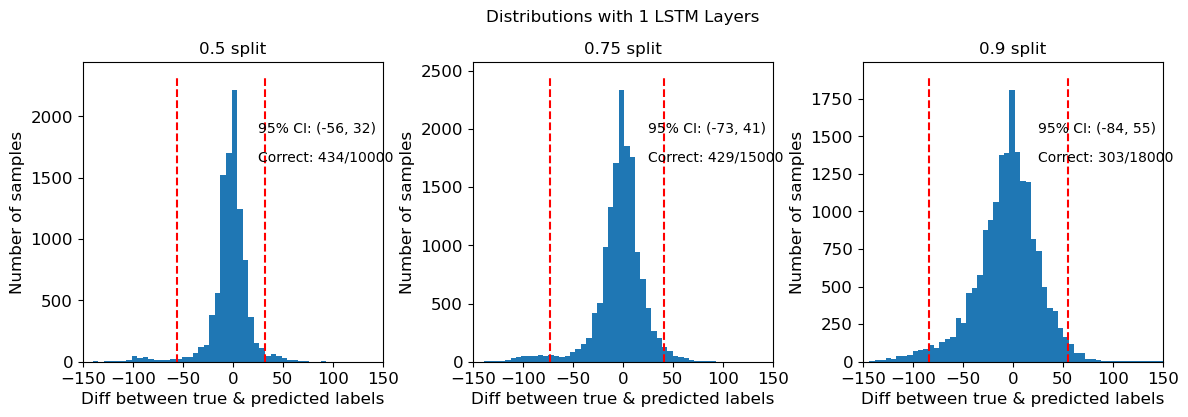

In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


def find_confidence_interval(data, confidence=0.95):
    """
    Calculate the confidence interval for a given dataset and confidence level.

    Parameters:
    data (np.array): The dataset as a NumPy array.
    confidence (float): The confidence level, default is 0.95 for a 95% confidence interval.

    Returns:
    tuple: A tuple containing the lower and upper bounds of the confidence interval.
    """
    # Sort the data
    sorted_data = np.sort(data)

    # Calculate the number of data points
    n = len(sorted_data)

    # Calculate indexes for the lower and upper bounds
    lower_index = int(n * ((1 - confidence) / 2))
    upper_index = int(n * (1 - (1 - confidence) / 2))

    # Extract values at these indexes
    lower_bound = sorted_data[lower_index]
    upper_bound = sorted_data[upper_index]

    return (lower_bound, upper_bound)


def plot_and_save_distributions(results, num_LSTM, splits, num_bins=200):
    plt.figure(figsize=(12, 4))  # Adjust the overall figure size as needed

    for index, split in enumerate(splits, 1):
        ax = plt.subplot(1, len(splits), index)  # Create a subplot for each split

        delta_labels = (
            results[split]["predicted_labels"] - results[split]["true_labels"]
        )
        plt.hist(delta_labels, bins=num_bins)
        num_correct_predicted = np.where(delta_labels == 0)[0].shape[0]
        confidence_interval = find_confidence_interval(delta_labels)

        ymax = plt.ylim()[1]
        plt.vlines(confidence_interval[0], 0, ymax, colors="r", linestyles="dashed")
        plt.vlines(confidence_interval[1], 0, ymax, colors="r", linestyles="dashed")
        plt.text(25, ymax * 0.8, f"95% CI: {confidence_interval}")
        plt.text(
            25, ymax * 0.7, f"Correct: {num_correct_predicted}/{delta_labels.shape[0]}"
        )

        plt.xlabel("Diff between true & predicted labels")
        plt.ylabel("Number of samples")
        plt.xlim(-150, 150)
        plt.title(f"{split} split")

        # Reduce the font size for better fit
        for item in (
            [ax.title, ax.xaxis.label, ax.yaxis.label]
            + ax.get_xticklabels()
            + ax.get_yticklabels()
        ):
            item.set_fontsize(12)

    plt.suptitle(
        f"Distributions with {num_LSTM} LSTM Layers", fontsize=12
    )  # Overall title for the figure
    plt.subplots_adjust(
        left=0.05, right=0.95, bottom=0.1, top=0.85, wspace=0.3, hspace=0.4
    )  # Adjust subplot spacing
    plt.savefig(f"+-dist_{num_LSTM}.png")  # Save the combined plot
    plt.show()
    plt.close()  # Close the figure to free memory


plot_and_save_distributions(results_p1_2_v1_int, 1, splits)

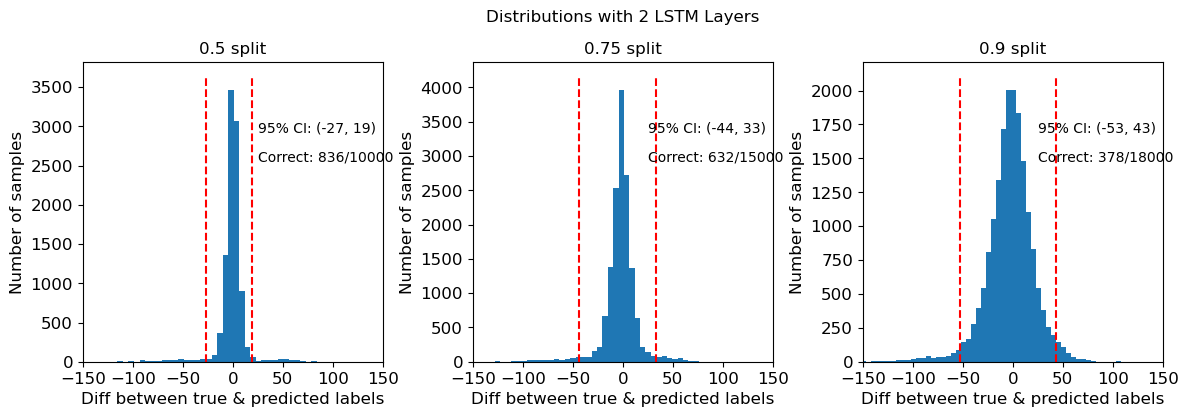

In [44]:
plot_and_save_distributions(results_p1_2_v2_int, 2, splits)

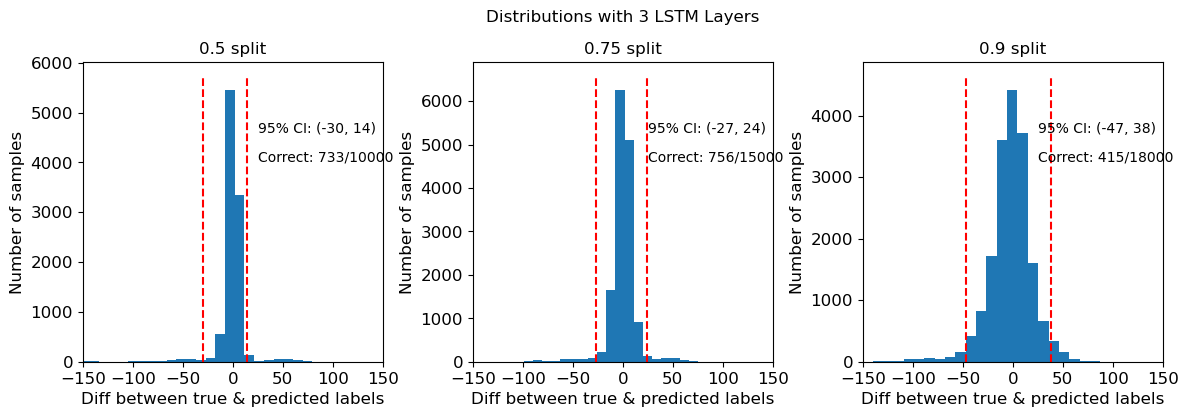

In [45]:
plot_and_save_distributions(results_p1_2_v3_int, 3, splits, num_bins=100)

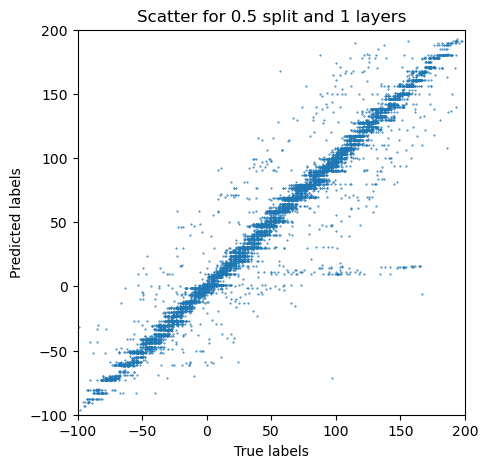

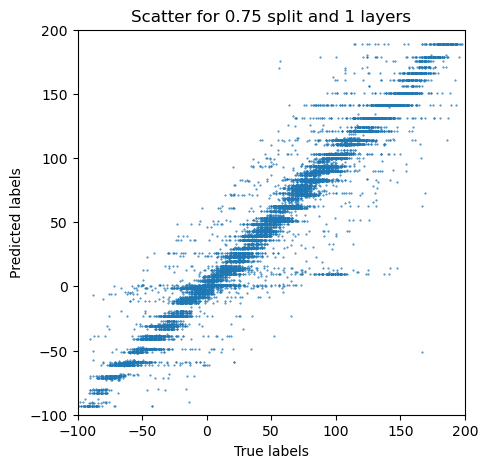

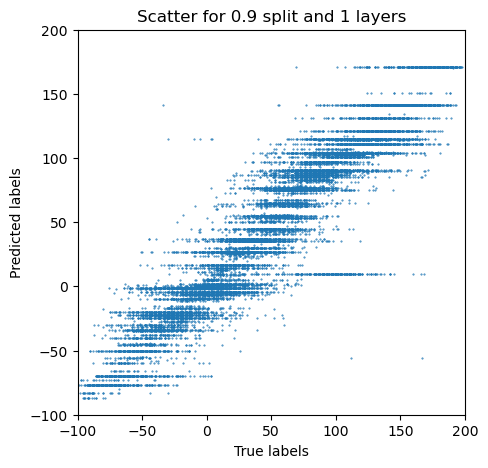

In [24]:
def plot_scatters(split, results, num_LMST):
    plt.figure(figsize=(5, 5))
    plt.scatter(
        results[split]["true_labels"],
        results[split]["predicted_labels"],
        s=0.2,
    )
    plt.ylabel("Predicted labels")
    plt.xlabel("True labels")
    plt.title(f"Scatter for {split} split and {num_LMST} layers")
    plt.ylim(-100, 200)
    plt.xlim(-100, 200)
    plt.savefig(f"+-scatter_{split}_{num_LMST}.png")
    plt.show()


for split in splits:
    plot_scatters(split, results_p1_2_v3, num_LMST=1)

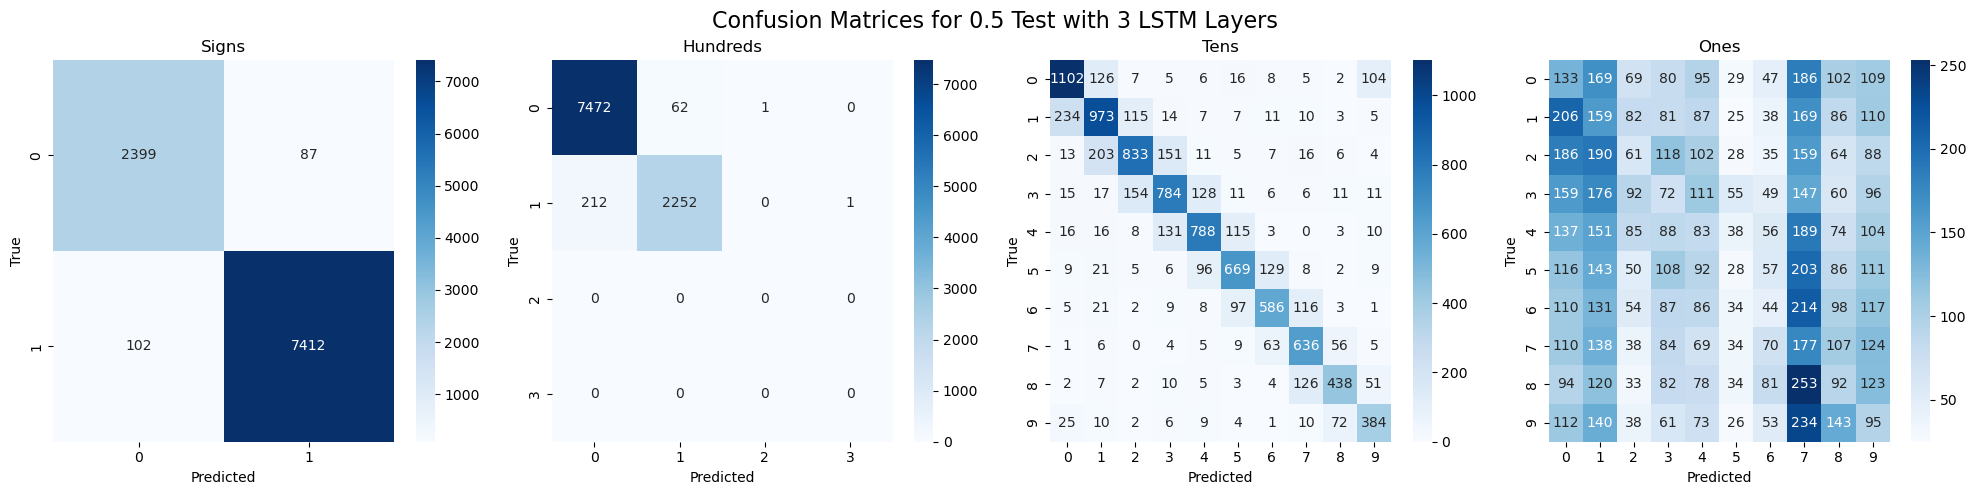

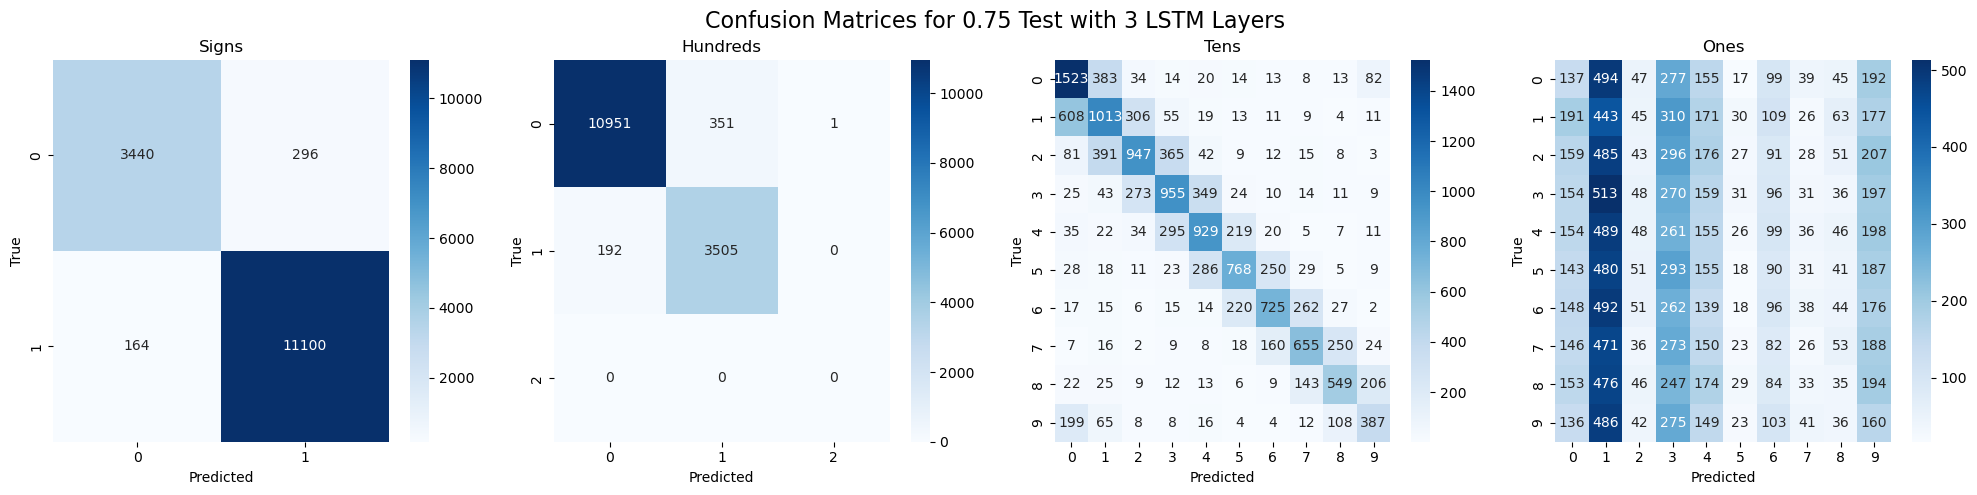

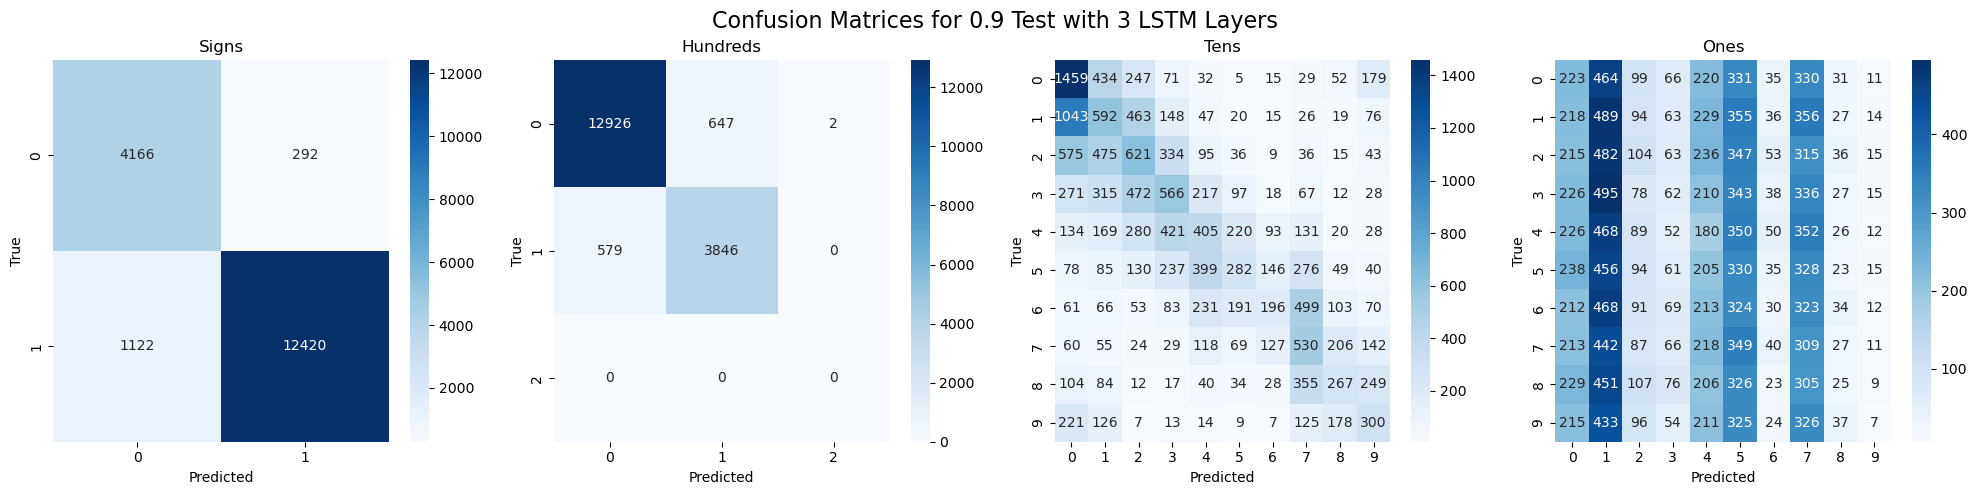

In [49]:
def plot_digit_confusion_matrices(results_dict, LSTM_layers):
    """This function plots the confusion matrices for each digit place (sign, hundreds, tens, ones) for each split in the results dictionary."""

    def extract_digits(labels):
        # Assumes labels are integers
        signs = []
        hundreds = []
        tens = []
        ones = []
        for label in labels:
            sign = -1 if label < 0 else 1
            abs_label = abs(label)
            hundred, remainder = divmod(abs_label, 100)
            ten, one = divmod(remainder, 10)
            signs.append(sign)
            hundreds.append(hundred)
            tens.append(ten)
            ones.append(one)
        return signs, hundreds, tens, ones

    def plot_confusion_matrix(y_true, y_pred, title, ax):
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
        ax.set_title(title)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")

    # Iterate over each split in the results dictionary
    for split, split_results in results_dict.items():
        true_labels = split_results["true_labels"]
        predicted_labels = split_results["predicted_labels"]

        true_signs, true_hundreds, true_tens, true_ones = extract_digits(true_labels)
        pred_signs, pred_hundreds, pred_tens, pred_ones = extract_digits(
            predicted_labels
        )

        # Setup the matplotlib figure and axes
        fig, axs = plt.subplots(1, 4, figsize=(20, 5))
        fig.suptitle(
            f"Confusion Matrices for {split} Test with {LSTM_layers} LSTM Layers",
            fontsize=16,
        )

        # Plot the confusion matrices for each digit place
        plot_confusion_matrix(true_signs, pred_signs, "Signs", axs[0])
        plot_confusion_matrix(true_hundreds, pred_hundreds, "Hundreds", axs[1])
        plot_confusion_matrix(true_tens, pred_tens, "Tens", axs[2])
        plot_confusion_matrix(true_ones, pred_ones, "Ones", axs[3])

        # Show the plot
        plt.tight_layout()
        plt.subplots_adjust(top=0.88)
        plt.savefig(f"+-confusion_matrices_{split}_{LSTM_layers}.png")
        plt.show()


# Example usage with your results dictionary
plot_digit_confusion_matrices(results_p1_2_v3, LSTM_layers=3)

---
---

## III. Text to image RNN Model

Hint: to make this model work really well you could use deconvolutional layers in your decoder (you might need to look up ***Conv2DTranspose*** layer). However, regular vector-based decoder will work as well.

The goal here is to use **X_text** as inputs and **y_img** as outputs.

In [9]:
# Your code


---
---
---

# Part 2: Multiplication
The cell below will create the multiplication dataset used in this part of the assignment.

In [50]:
# Illustrate the generated query/answer pairs

unique_characters = "0123456789* "  # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99  # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))  # Maximum number of characters in an integer
max_query_length = (
    max_int_length * 2 + 1
)  # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 5  # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text2, X_img2, y_text2, y_img2 = create_data(highest_integer, operands=["*"])
print(X_text2.shape, X_img2.shape, y_text2.shape, y_img2.shape)


## Display the samples that were created
def display_sample(n):
    labels = ["X_img:", "y_img:"]
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1, 2, i + 1)
        # plt.set_figheight(15)
        plt.axis("off")
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap="gray")
    print("=" * 50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()


"""for _ in range(10):
    display_sample(np.random.randint(0, 10000, 1)[0])"""

(10000,) (10000, 5, 28, 28) (10000,) (10000, 5, 28, 28)


'for _ in range(10):\n    display_sample(np.random.randint(0, 10000, 1)[0])'

### Image-to-Text Model

In [51]:
## Your code

X_text2_onehot = encode_labels(X_text2)
y_text2_onehot = encode_labels(y_text2)

# Modified training and evaluation for different splits
splits = [0.5, 0.75, 0.9]  # Train-test splits, the number is the ratio of test data
# the out put from model with two LSTM layers in encoder
results_p2_2_v1 = {}

for split in splits:
    print(f"Training with {1-split} Train - {split} Test split")
    accuracy, true_labels, predicted_labels = train_and_evaluate(
        split, X_img2, y_text2_onehot, build_image_to_text_model()
    )
    results_p2_2_v1[split] = {
        "accuracy": accuracy,
        "true_labels": true_labels,
        "predicted_labels": predicted_labels,
    }

Training with 0.5 Train - 0.5 Test split


2023-12-06 16:51:35.167233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 16:51:35.168709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 16:51:35.169593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_18 (TimeDi  (None, 5, 784)           0         
 stributed)                                                      
                                                                 
 lstm_27 (LSTM)              (None, 384)               1795584   
                                                                 
 repeat_vector_9 (RepeatVect  (None, 5, 384)           0         
 or)                                                             
                                                                 
 lstm_28 (LSTM)              (None, 5, 384)            1181184   
                                                                 
 time_distributed_19 (TimeDi  (None, 5, 12)            4620      
 stributed)                                                      
                                                      

2023-12-06 16:51:35.403550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 16:51:35.404861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 16:51:35.406073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2023-12-06 16:51:35.914498: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 16:51:35.915684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 16:51:35.917615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

156/157 [============================>.] - ETA: 0s - loss: 1.7468 - accuracy: 0.3727

2023-12-06 16:51:49.675200: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 16:51:49.677122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 16:51:49.678276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

157/157 [==============================] - 17s 88ms/step - loss: 1.7468 - accuracy: 0.3727 - val_loss: 1.6050 - val_accuracy: 0.4094
Epoch 2/20
157/157 [==============================] - 13s 81ms/step - loss: 1.5755 - accuracy: 0.4148 - val_loss: 1.5541 - val_accuracy: 0.4228
Epoch 3/20
157/157 [==============================] - 14s 89ms/step - loss: 1.4943 - accuracy: 0.4444 - val_loss: 1.4901 - val_accuracy: 0.4416
Epoch 4/20
157/157 [==============================] - 13s 85ms/step - loss: 1.4178 - accuracy: 0.4666 - val_loss: 1.4550 - val_accuracy: 0.4515
Epoch 5/20
157/157 [==============================] - 13s 85ms/step - loss: 1.3414 - accuracy: 0.4906 - val_loss: 1.4264 - val_accuracy: 0.4631
Epoch 6/20
157/157 [==============================] - 13s 82ms/step - loss: 1.2641 - accuracy: 0.5194 - val_loss: 1.4105 - val_accuracy: 0.4677
Epoch 7/20
157/157 [==============================] - 13s 83ms/step - loss: 1.1774 - accuracy: 0.5546 - val_loss: 1.4774 - val_accuracy: 0.4710
Epo

2023-12-06 16:56:08.077782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 16:56:08.079906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 16:56:08.081129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

157/157 [==============================] - 3s 13ms/step
Training with 0.25 Train - 0.75 Test split


2023-12-06 16:56:10.834365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 16:56:10.835400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 16:56:10.836467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_20 (TimeDi  (None, 5, 784)           0         
 stributed)                                                      
                                                                 
 lstm_29 (LSTM)              (None, 384)               1795584   
                                                                 
 repeat_vector_10 (RepeatVec  (None, 5, 384)           0         
 tor)                                                            
                                                                 
 lstm_30 (LSTM)              (None, 5, 384)            1181184   
                                                                 
 time_distributed_21 (TimeDi  (None, 5, 12)            4620      
 stributed)                                                      
                                                     

2023-12-06 16:56:11.062416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 16:56:11.063380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 16:56:11.064436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2023-12-06 16:56:11.483129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 16:56:11.484266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 16:56:11.485406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

78/79 [============================>.] - ETA: 0s - loss: 1.8050 - accuracy: 0.3585

2023-12-06 16:56:19.450545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-06 16:56:19.451541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-06 16:56:19.452652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

79/79 [==============================] - 12s 115ms/step - loss: 1.8045 - accuracy: 0.3588 - val_loss: 1.7041 - val_accuracy: 0.3859
Epoch 2/20
79/79 [==============================] - 9s 113ms/step - loss: 1.6386 - accuracy: 0.3962 - val_loss: 1.6460 - val_accuracy: 0.3977
Epoch 3/20
79/79 [==============================] - 9s 119ms/step - loss: 1.5752 - accuracy: 0.4142 - val_loss: 1.6068 - val_accuracy: 0.4108
Epoch 4/20
79/79 [==============================] - 9s 118ms/step - loss: 1.5326 - accuracy: 0.4276 - val_loss: 1.5791 - val_accuracy: 0.4196
Epoch 5/20
79/79 [==============================] - 9s 117ms/step - loss: 1.4754 - accuracy: 0.4538 - val_loss: 1.5281 - val_accuracy: 0.4334
Epoch 6/20
79/79 [==============================] - 9s 119ms/step - loss: 1.4127 - accuracy: 0.4760 - val_loss: 1.5340 - val_accuracy: 0.4346
Epoch 7/20
79/79 [==============================] - 9s 112ms/step - loss: 1.3427 - accuracy: 0.4998 - val_loss: 1.5448 - val_accuracy: 0.4299
Epoch 8/20
79/79

In [ ]:
# the out put from model with two LSTM layers in encoder
results_p2_2_v2 = {}

for split in splits:
    print(f"Training with {1-split} Train - {split} Test split")
    accuracy, true_labels, predicted_labels = train_and_evaluate(
        split, X_img2, y_text2_onehot, build_image_to_text_model_v2()
    )
    results_p2_2_v2[split] = {
        "accuracy": accuracy,
        "true_labels": true_labels,
        "predicted_labels": predicted_labels,
    }

Training with 0.5 Train - 0.5 Test split


2023-12-05 01:00:26.071786: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-05 01:00:26.072766: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-05 01:00:26.073989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_32 (TimeDi  (None, 5, 784)           0         
 stributed)                                                      
                                                                 
 lstm_42 (LSTM)              (None, 5, 384)            1795584   
                                                                 
 lstm_43 (LSTM)              (None, 384)               1181184   
                                                                 
 repeat_vector_16 (RepeatVec  (None, 5, 384)           0         
 tor)                                                            
                                                                 
 lstm_44 (LSTM)              (None, 5, 384)            1181184   
                                                                 
 time_distributed_33 (TimeDi  (None, 5, 12)          

2023-12-05 01:00:26.536537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-05 01:00:26.538390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-05 01:00:26.539618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2023-12-05 01:00:27.027859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-05 01:00:27.029112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-05 01:00:27.030670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

157/157 [==============================] - ETA: 0s - loss: 1.7442 - accuracy: 0.3743

2023-12-05 01:00:45.759376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-05 01:00:45.761350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-05 01:00:45.762542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

157/157 [==============================] - 23s 116ms/step - loss: 1.7442 - accuracy: 0.3743 - val_loss: 1.6281 - val_accuracy: 0.4020
Epoch 2/20
157/157 [==============================] - 20s 130ms/step - loss: 1.6004 - accuracy: 0.4065 - val_loss: 1.5709 - val_accuracy: 0.4151
Epoch 3/20
157/157 [==============================] - 22s 137ms/step - loss: 1.5118 - accuracy: 0.4377 - val_loss: 1.5241 - val_accuracy: 0.4414
Epoch 4/20
157/157 [==============================] - 22s 138ms/step - loss: 1.4120 - accuracy: 0.4659 - val_loss: 1.4296 - val_accuracy: 0.4581
Epoch 5/20
157/157 [==============================] - 21s 137ms/step - loss: 1.3348 - accuracy: 0.4839 - val_loss: 1.3695 - val_accuracy: 0.4773
Epoch 6/20
157/157 [==============================] - 21s 136ms/step - loss: 1.2668 - accuracy: 0.5036 - val_loss: 1.3634 - val_accuracy: 0.4822
Epoch 7/20
157/157 [==============================] - 21s 135ms/step - loss: 1.1990 - accuracy: 0.5249 - val_loss: 1.3363 - val_accuracy: 0.4

2023-12-05 01:07:38.993414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-05 01:07:38.995014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-05 01:07:38.996338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

157/157 [==============================] - 5s 25ms/step
Training with 0.25 Train - 0.75 Test split


2023-12-05 01:07:43.875314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-05 01:07:43.876432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-05 01:07:43.879268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_34 (TimeDi  (None, 5, 784)           0         
 stributed)                                                      
                                                                 
 lstm_45 (LSTM)              (None, 5, 384)            1795584   
                                                                 
 lstm_46 (LSTM)              (None, 384)               1181184   
                                                                 
 repeat_vector_17 (RepeatVec  (None, 5, 384)           0         
 tor)                                                            
                                                                 
 lstm_47 (LSTM)              (None, 5, 384)            1181184   
                                                                 
 time_distributed_35 (TimeDi  (None, 5, 12)          

2023-12-05 01:07:44.372992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-05 01:07:44.373926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-05 01:07:44.375004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2023-12-05 01:07:44.944552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-05 01:07:44.946356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-05 01:07:44.947596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

79/79 [==============================] - ETA: 0s - loss: 1.8436 - accuracy: 0.3512

2023-12-05 01:07:57.998191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-05 01:07:57.999157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-05 01:07:58.000228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

79/79 [==============================] - 20s 197ms/step - loss: 1.8436 - accuracy: 0.3512 - val_loss: 1.6943 - val_accuracy: 0.3845
Epoch 2/20
79/79 [==============================] - 15s 185ms/step - loss: 1.6692 - accuracy: 0.3895 - val_loss: 1.6359 - val_accuracy: 0.4048
Epoch 3/20
79/79 [==============================] - 15s 189ms/step - loss: 1.6061 - accuracy: 0.4042 - val_loss: 1.5842 - val_accuracy: 0.4130
Epoch 4/20
79/79 [==============================] - 15s 186ms/step - loss: 1.5543 - accuracy: 0.4212 - val_loss: 1.5369 - val_accuracy: 0.4314
Epoch 5/20
79/79 [==============================] - 14s 182ms/step - loss: 1.5053 - accuracy: 0.4385 - val_loss: 1.5415 - val_accuracy: 0.4333
Epoch 6/20
79/79 [==============================] - 14s 181ms/step - loss: 1.4368 - accuracy: 0.4588 - val_loss: 1.4888 - val_accuracy: 0.4447
Epoch 7/20
79/79 [==============================] - 14s 181ms/step - loss: 1.3749 - accuracy: 0.4681 - val_loss: 1.4794 - val_accuracy: 0.4489
Epoch 8/20

2023-12-05 01:12:22.248753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-05 01:12:22.249728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-05 01:12:22.251258: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

235/235 [==============================] - 5s 19ms/step
Training with 0.09999999999999998 Train - 0.9 Test split


2023-12-05 01:12:27.628210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-05 01:12:27.629122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-05 01:12:27.630204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_36 (TimeDi  (None, 5, 784)           0         
 stributed)                                                      
                                                                 
 lstm_48 (LSTM)              (None, 5, 384)            1795584   
                                                                 
 lstm_49 (LSTM)              (None, 384)               1181184   
                                                                 
 repeat_vector_18 (RepeatVec  (None, 5, 384)           0         
 tor)                                                            
                                                                 
 lstm_50 (LSTM)              (None, 5, 384)            1181184   
                                                                 
 time_distributed_37 (TimeDi  (None, 5, 12)          

2023-12-05 01:12:28.082050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-05 01:12:28.083014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-05 01:12:28.084094: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2023-12-05 01:12:28.507735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-05 01:12:28.508821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-05 01:12:28.510180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - ETA: 0s - loss: 1.9684 - accuracy: 0.3204

2023-12-05 01:12:35.882839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-05 01:12:35.883840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-05 01:12:35.884947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 13s 278ms/step - loss: 1.9684 - accuracy: 0.3204 - val_loss: 1.8411 - val_accuracy: 0.3665
Epoch 2/20
32/32 [==============================] - 8s 243ms/step - loss: 1.8027 - accuracy: 0.3680 - val_loss: 1.7293 - val_accuracy: 0.3850
Epoch 3/20
32/32 [==============================] - 8s 241ms/step - loss: 1.7168 - accuracy: 0.3766 - val_loss: 1.6766 - val_accuracy: 0.3938
Epoch 4/20
32/32 [==============================] - 7s 235ms/step - loss: 1.6758 - accuracy: 0.3872 - val_loss: 1.6540 - val_accuracy: 0.3960
Epoch 5/20
32/32 [==============================] - 8s 245ms/step - loss: 1.6271 - accuracy: 0.4004 - val_loss: 1.6258 - val_accuracy: 0.4031
Epoch 6/20
32/32 [==============================] - 8s 245ms/step - loss: 1.5951 - accuracy: 0.4086 - val_loss: 1.6335 - val_accuracy: 0.3945
Epoch 7/20
32/32 [==============================] - 8s 247ms/step - loss: 1.5646 - accuracy: 0.4246 - val_loss: 1.6409 - val_accuracy: 0.4029
Epoch 8/20
32/32

2023-12-05 01:15:15.947327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-05 01:15:15.948276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-05 01:15:15.949368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

282/282 [==============================] - 6s 19ms/step


In [ ]:
# the out put from model with two LSTM layers in encoder
results_p2_2_v3 = {}

for split in splits:
    print(f"Training with {1-split} Train - {split} Test split")
    accuracy, true_labels, predicted_labels = train_and_evaluate(
        split, X_img2, y_text2_onehot, build_image_to_text_model_v3()
    )
    results_p2_2_v3[split] = {
        "accuracy": accuracy,
        "true_labels": true_labels,
        "predicted_labels": predicted_labels,
    }

Training with 0.5 Train - 0.5 Test split


2023-12-05 12:41:42.207316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-05 12:41:42.209092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-05 12:41:42.210996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_38 (TimeDi  (None, 5, 784)           0         
 stributed)                                                      
                                                                 
 lstm_51 (LSTM)              (None, 5, 384)            1795584   
                                                                 
 lstm_52 (LSTM)              (None, 5, 384)            1181184   
                                                                 
 lstm_53 (LSTM)              (None, 384)               1181184   
                                                                 
 repeat_vector_19 (RepeatVec  (None, 5, 384)           0         
 tor)                                                            
                                                                 
 lstm_54 (LSTM)              (None, 5, 384)          

2023-12-05 12:41:43.165056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-05 12:41:43.166733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-05 12:41:43.167800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2023-12-05 12:41:44.386681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-05 12:41:44.388274: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-05 12:41:44.389565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

157/157 [==============================] - ETA: 0s - loss: 1.8481 - accuracy: 0.3521

2023-12-05 12:42:09.968298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-05 12:42:09.969552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-05 12:42:09.970544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

157/157 [==============================] - 31s 159ms/step - loss: 1.8481 - accuracy: 0.3521 - val_loss: 1.6728 - val_accuracy: 0.3932
Epoch 2/20
157/157 [==============================] - 24s 154ms/step - loss: 1.6573 - accuracy: 0.3940 - val_loss: 1.6070 - val_accuracy: 0.4093
Epoch 3/20
157/157 [==============================] - 24s 153ms/step - loss: 1.5750 - accuracy: 0.4182 - val_loss: 1.5161 - val_accuracy: 0.4373
Epoch 4/20
157/157 [==============================] - 23s 146ms/step - loss: 1.4875 - accuracy: 0.4473 - val_loss: 1.4623 - val_accuracy: 0.4491
Epoch 5/20
157/157 [==============================] - 23s 147ms/step - loss: 1.3971 - accuracy: 0.4676 - val_loss: 1.3956 - val_accuracy: 0.4677
Epoch 6/20
157/157 [==============================] - 24s 156ms/step - loss: 1.3081 - accuracy: 0.4904 - val_loss: 1.3992 - val_accuracy: 0.4673
Epoch 7/20
157/157 [==============================] - 24s 150ms/step - loss: 1.2511 - accuracy: 0.5064 - val_loss: 1.3414 - val_accuracy: 0.4

2023-12-05 12:50:58.257156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-05 12:50:58.260257: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-05 12:50:58.262657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

157/157 [==============================] - 12s 41ms/step
Training with 0.25 Train - 0.75 Test split


2023-12-05 12:51:10.642325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-05 12:51:10.644883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-05 12:51:10.647061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_40 (TimeDi  (None, 5, 784)           0         
 stributed)                                                      
                                                                 
 lstm_55 (LSTM)              (None, 5, 384)            1795584   
                                                                 
 lstm_56 (LSTM)              (None, 5, 384)            1181184   
                                                                 
 lstm_57 (LSTM)              (None, 384)               1181184   
                                                                 
 repeat_vector_20 (RepeatVec  (None, 5, 384)           0         
 tor)                                                            
                                                                 
 lstm_58 (LSTM)              (None, 5, 384)          

2023-12-05 12:51:12.103600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-05 12:51:12.106186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-05 12:51:12.108175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2023-12-05 12:51:12.981794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-05 12:51:12.984102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-05 12:51:12.985979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

79/79 [==============================] - ETA: 0s - loss: 1.9133 - accuracy: 0.3332

2023-12-05 12:51:34.157808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-05 12:51:34.160377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-05 12:51:34.162630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

79/79 [==============================] - 31s 261ms/step - loss: 1.9133 - accuracy: 0.3332 - val_loss: 1.8178 - val_accuracy: 0.3655
Epoch 2/20
79/79 [==============================] - 17s 212ms/step - loss: 1.7269 - accuracy: 0.3758 - val_loss: 1.6777 - val_accuracy: 0.3910
Epoch 3/20
79/79 [==============================] - 16s 207ms/step - loss: 1.6701 - accuracy: 0.3874 - val_loss: 1.6470 - val_accuracy: 0.3911
Epoch 4/20
79/79 [==============================] - 16s 206ms/step - loss: 1.6237 - accuracy: 0.3977 - val_loss: 1.6506 - val_accuracy: 0.3884
Epoch 5/20
79/79 [==============================] - 16s 208ms/step - loss: 1.5802 - accuracy: 0.4131 - val_loss: 1.6087 - val_accuracy: 0.4086
Epoch 6/20
79/79 [==============================] - 17s 214ms/step - loss: 1.5391 - accuracy: 0.4254 - val_loss: 1.5889 - val_accuracy: 0.4199
Epoch 7/20
79/79 [==============================] - 17s 215ms/step - loss: 1.4951 - accuracy: 0.4405 - val_loss: 1.5096 - val_accuracy: 0.4388
Epoch 8/20

2023-12-05 12:57:21.254121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-05 12:57:21.256069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-05 12:57:21.257534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

235/235 [==============================] - 9s 30ms/step
Training with 0.09999999999999998 Train - 0.9 Test split


2023-12-05 12:57:30.270974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-05 12:57:30.272441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-05 12:57:30.273985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_42 (TimeDi  (None, 5, 784)           0         
 stributed)                                                      
                                                                 
 lstm_59 (LSTM)              (None, 5, 384)            1795584   
                                                                 
 lstm_60 (LSTM)              (None, 5, 384)            1181184   
                                                                 
 lstm_61 (LSTM)              (None, 384)               1181184   
                                                                 
 repeat_vector_21 (RepeatVec  (None, 5, 384)           0         
 tor)                                                            
                                                                 
 lstm_62 (LSTM)              (None, 5, 384)          

2023-12-05 12:57:31.302479: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-05 12:57:31.303938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-05 12:57:31.305492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2023-12-05 12:57:31.901382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-05 12:57:31.904034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-05 12:57:31.905971: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - ETA: 0s - loss: 2.0921 - accuracy: 0.2954

2023-12-05 12:57:43.799810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-05 12:57:43.801065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-05 12:57:43.802413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 21s 418ms/step - loss: 2.0921 - accuracy: 0.2954 - val_loss: 1.8454 - val_accuracy: 0.3550
Epoch 2/20
32/32 [==============================] - 13s 401ms/step - loss: 1.8341 - accuracy: 0.3556 - val_loss: 1.8333 - val_accuracy: 0.3572
Epoch 3/20
32/32 [==============================] - 13s 407ms/step - loss: 1.8135 - accuracy: 0.3572 - val_loss: 1.7779 - val_accuracy: 0.3585
Epoch 4/20
32/32 [==============================] - 13s 411ms/step - loss: 1.7372 - accuracy: 0.3684 - val_loss: 1.6926 - val_accuracy: 0.3864
Epoch 5/20
32/32 [==============================] - 13s 414ms/step - loss: 1.6924 - accuracy: 0.3784 - val_loss: 1.6860 - val_accuracy: 0.3854
Epoch 6/20
32/32 [==============================] - 12s 392ms/step - loss: 1.6694 - accuracy: 0.3852 - val_loss: 1.6511 - val_accuracy: 0.3971
Epoch 7/20
32/32 [==============================] - 12s 377ms/step - loss: 1.6217 - accuracy: 0.4022 - val_loss: 1.7474 - val_accuracy: 0.3813
Epoch 8/20

2023-12-05 13:01:59.813072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-05 13:01:59.815416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-05 13:01:59.817509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

282/282 [==============================] - 11s 32ms/step


In [33]:
for split in splits:
    print(f"Accuracy for {1-split} Train - {split} Test split:")
    print(f"Model with 1 LSTM layer: {results_p2_2_v1[split]['accuracy']}")
    print(f"Model with 2 LSTM layers: {results_p2_2_v2[split]['accuracy']}")
    print(f"Model with 3 LSTM layers: {results_p2_2_v3[split]['accuracy']}")
    print()

Accuracy for 0.5 Train - 0.5 Test split:
Model with 1 LSTM layer: 0.4877600073814392
Model with 2 LSTM layers: 0.5217199921607971
Model with 3 LSTM layers: 0.5395600199699402

Accuracy for 0.25 Train - 0.75 Test split:
Model with 1 LSTM layer: 0.4479733407497406
Model with 2 LSTM layers: 0.46613332629203796
Model with 3 LSTM layers: 0.47893333435058594

Accuracy for 0.09999999999999998 Train - 0.9 Test split:
Model with 1 LSTM layer: 0.4005777835845947
Model with 2 LSTM layers: 0.40815556049346924
Model with 3 LSTM layers: 0.4081999957561493



In [34]:
for split in splits:
    print(f"Accuracy for {1-split} Train - {split} Test split:")
    print(f"Model with 1 LSTM layer: {results_p1_2_v1[split]['accuracy']}")
    print(f"Model with 2 LSTM layers: {results_p1_2_v2[split]['accuracy']}")
    print(f"Model with 3 LSTM layers: {results_p1_2_v3[split]['accuracy']}")
    print()

Accuracy for 0.5 Train - 0.5 Test split:
Model with 1 LSTM layer: 0.49123331904411316
Model with 2 LSTM layers: 0.5824000239372253
Model with 3 LSTM layers: 0.5894666910171509

Accuracy for 0.25 Train - 0.75 Test split:
Model with 1 LSTM layer: 0.43788889050483704
Model with 2 LSTM layers: 0.4984889030456543
Model with 3 LSTM layers: 0.5342666506767273

Accuracy for 0.09999999999999998 Train - 0.9 Test split:
Model with 1 LSTM layer: 0.38805556297302246
Model with 2 LSTM layers: 0.4019814729690552
Model with 3 LSTM layers: 0.4252592623233795

